# Momentum Strategy Project

In [7]:
# ==== Project-safe imports: avoid 3rd-party name collisions, use package style ====
import sys, os
from pathlib import Path

root = Path.cwd()
while root != root.parent and not (root / "src" / "__init__.py").exists():
    root = root.parent
if not (root / "src" / "__init__.py").exists():
    raise RuntimeError("Cannot find project root containing src/__init__.py")

sys.path.insert(0, str(root))

for m in ["src", "src.cleaning", "src.features", "src.portfolio", "src.backtest", "src.utils",
          "backtest"]:  # 顶层第三方包名
    sys.modules.pop(m, None)

from src.cleaning import basic_describe, forward_fill, to_monthly, pct_change_monthly, winsorize_returns
from src.features  import momentum_12_1, binary_map
from src.portfolio import ledoit_wolf_cov, min_var_weights
from src.backtest  import walkforward_minvar, fixedsplit_minvar, build_benchmarks, summarize
from src.utils     import to_nav

import inspect, src.backtest as bt
print("Project root:", root)
print("Using backtest from:", inspect.getsourcefile(bt))  # 应指向 .../your_project/src/backtest.py


Project root: /Users/mengmeng/bootcamp_Shuchen_Meng/project
Using backtest from: /Users/mengmeng/bootcamp_Shuchen_Meng/project/src/backtest.py


In [8]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
warnings.filterwarnings('ignore')
BASE=os.path.abspath(os.path.join(os.getcwd(),'..'))
DATA_RAW=os.path.join(BASE,'data','raw'); DATA_PROC=os.path.join(BASE,'data','processed'); REPORTS=os.path.join(BASE,'reports'); SRC=os.path.join(BASE,'src')
print('Paths ready.')


Paths ready.


In [9]:
TICKERS=['SPY','QQQ','EEM']; BOND='AGG'; START='2005-01-01'; END=None
COST_BPS_PER_SIDE=15.0; WINDOW_COV_MONTHS=60; WMAX=0.25; SPLIT_RATIO=0.8


### Download data (Adj Close)

In [10]:
def download_adj_close(tickers, start, end=None):
    tickers = list(dict.fromkeys(tickers))  # 去重且保持顺序
    # 尝试多票一次下
    df = yf.download(
        tickers, start=start, end=end, interval="1d",
        auto_adjust=True, actions=False, group_by="ticker",
        threads=False, progress=False
    )
    
    result = pd.DataFrame()
    if isinstance(df.columns, pd.MultiIndex):
        # 结构：顶层是 ticker，第二层是字段（Close/Volume...）
        cols = {}
        for t in tickers:
            sub = df.get(t)
            if sub is None or sub.empty:
                continue
            if "Close" in sub.columns:
                cols[t] = sub["Close"]
            elif "close" in sub.columns:
                cols[t] = sub["close"]
        if cols:
            result = pd.DataFrame(cols)
    else:
        # 只有单票时是普通列
        if "Close" in df.columns:
            result = df[["Close"]].rename(columns={"Close": tickers[0]})
        elif "close" in df.columns:
            result = df[["close"]].rename(columns={"close": tickers[0]})

    # 兜底：逐票下载再拼接（防止一次性下载拿不到）
    missing = [t for t in tickers if t not in result.columns]
    if result.empty or missing:
        frames = []
        for t in tickers:
            x = yf.download(
                t, start=start, end=end, interval="1d",
                auto_adjust=True, actions=False, progress=False, threads=False
            )
            if not x.empty:
                col = "Close" if "Close" in x.columns else ("close" if "close" in x.columns else None)
                if col:
                    frames.append(x[col].rename(t))
        if frames:
            result = pd.concat(frames, axis=1)
    return result.sort_index().dropna(how="all")

In [11]:
tickers_all = list(dict.fromkeys(TICKERS + [BOND])) 
prices = download_adj_close(tickers_all, START, END)

# dowload
raw_path = os.path.join(DATA_RAW, "adj_close_daily.csv")
prices.to_csv(raw_path, index=True)
print("Saved:", raw_path, "| shape:", prices.shape)
prices.tail()

Saved: /Users/mengmeng/bootcamp_Shuchen_Meng/project/data/raw/adj_close_daily.csv | shape: (5195, 4)


,SPY,QQQ,EEM,AGG
Date,,,,
2025-08-20,638.109985,565.900024,49.750000,99.080002
2025-08-21,635.549988,563.280029,49.639999,98.849998
2025-08-22,645.309998,571.969971,50.630001,99.400002
2025-08-25,642.469971,570.320007,50.340000,99.250000
2025-08-26,645.159973,572.609985,50.209999,99.370003


### Clean → monthly returns & features

In [12]:
import inspect
import src.cleaning as cleaning  # 强制用我们项目里的
print("forward_fill from:", inspect.getsourcefile(cleaning.forward_fill))

forward_fill from: /Users/mengmeng/bootcamp_Shuchen_Meng/project/src/cleaning.py


In [14]:
prices_=forward_fill(prices)
prices_m=to_monthly(prices_)
rets_m=pct_change_monthly(prices_m)
rets_m_w=winsorize_returns(rets_m,0.01,0.99)
mom=momentum_12_1(prices_m[TICKERS])
sig=binary_map(mom)
sig.tail()

,SPY,QQQ,EEM
Date,,,
2025-04-30,1,1,1
2025-05-31,1,1,1
2025-06-30,1,1,1
2025-07-31,1,1,1
2025-08-31,1,1,1


In [15]:
# --- Sanity check: 确认月频价格是合理的 ---
print("Monthly index:", prices_m.index.min().date(), "→", prices_m.index.max().date(), "| n=", len(prices_m))
display(prices_m[TICKERS].tail())

Monthly index: 2005-01-31 → 2025-08-31 | n= 248


,SPY,QQQ,EEM
Date,,,
2025-04-30,552.905457,474.936615,43.340141
2025-05-31,587.652771,518.527649,45.083256
2025-06-30,617.849976,551.640015,48.240002
2025-07-31,632.080017,565.010010,48.560001
2025-08-31,645.159973,572.609985,50.209999


In [16]:

sel_cnt = sig.sum(axis=1)
display(sel_cnt.tail(10))

WMAX = max(0.25, 1/len(TICKERS))
print("Any infeasible month? ", ((sel_cnt * WMAX) < 1).tail(10).any())

display(mom.tail())
display(sig.tail())

Date
2024-11-30    3
2024-12-31    3
2025-01-31    3
2025-02-28    3
2025-03-31    3
2025-04-30    3
2025-05-31    3
2025-06-30    3
2025-07-31    3
2025-08-31    3
Freq: ME, dtype: int64

Any infeasible month?  False


,SPY,QQQ,EEM
Date,,,
2025-04-30,0.146955,0.149782,0.076993
2025-05-31,0.128550,0.111157,0.091598
2025-06-30,0.064903,0.061384,0.072171
2025-07-31,0.093257,0.088381,0.086839
2025-08-31,0.135683,0.177645,0.153192


,SPY,QQQ,EEM
Date,,,
2025-04-30,1,1,1
2025-05-31,1,1,1
2025-06-30,1,1,1
2025-07-31,1,1,1
2025-08-31,1,1,1


### Backtests: walk-forward and 80/20 control

In [17]:
wf=walkforward_minvar(prices_m[TICKERS], sig, window_cov_months=WINDOW_COV_MONTHS, wmax=WMAX, cost_bps_per_side=COST_BPS_PER_SIDE)
fx=fixedsplit_minvar(prices_m[TICKERS], sig, split_ratio=SPLIT_RATIO, window_cov_months=WINDOW_COV_MONTHS, wmax=WMAX, cost_bps_per_side=COST_BPS_PER_SIDE)
wf_nav=to_nav(wf['returns']); fx_nav=to_nav(fx['returns'])
bench=build_benchmarks(prices_m[TICKERS], prices_m[BOND]); ew_nav=to_nav(bench['EW']); sf_nav=to_nav(bench['60/40']); spy_nav=to_nav(bench['SPY'])


### Summary tables & plots

In [20]:
panel = pd.concat({
    "Strategy (WalkFwd)": wf_nav,
    "Strategy (80/20)":   fx_nav,
    "Equal-Weight":       ew_nav,
    "60/40":              sf_nav,
    "SPY":                spy_nav,
}, axis=1)

# strict alignment: drop rows where any series is NaN
panel = panel.dropna(how="any")
navs_clean = {c: panel[c] for c in panel.columns}

perf = summarize(navs_clean).round(4)
display(perf)

,CAGR,Sharpe (ann),Max Drawdown
Strategy,,,
Strategy (WalkFwd),0.0850,0.5673,-0.2977
Strategy (80/20),0.0850,0.5673,-0.2977
Equal-Weight,0.0875,0.6003,-0.2796
60/40,0.0657,0.5969,-0.2005
SPY,0.1145,0.7442,-0.2393


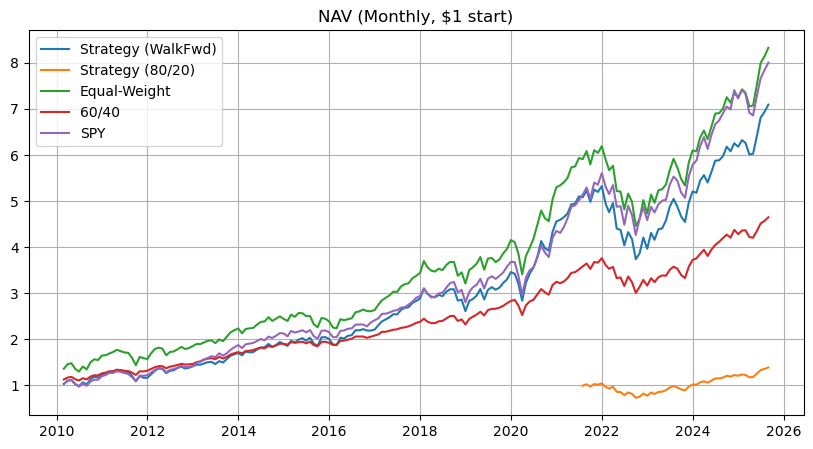

In [21]:
import matplotlib.pyplot as plt
common=wf_nav.index.intersection(ew_nav.index).intersection(sf_nav.index).intersection(spy_nav.index)
navs={'Strategy (WalkFwd)': wf_nav.reindex(common).ffill(),
      'Strategy (80/20)': fx_nav.reindex(common).ffill(),
      'Equal-Weight': ew_nav.reindex(common).ffill(),
      '60/40': sf_nav.reindex(common).ffill(),
      'SPY': spy_nav.reindex(common).ffill()}
plt.figure(figsize=(10,5))
for k,v in navs.items(): plt.plot(v.index, v.values, label=k)
plt.title('NAV (Monthly, $1 start)'); plt.legend(); plt.grid(True); plt.savefig(os.path.join(REPORTS,'nav.png'),dpi=150); plt.show()


# Momentum Strategy — Results Report (Plain Text)

- Universe: SPY, QQQ, EEM (monthly, adjusted prices)
- Signal: 12–1 momentum (skip last month), binarized (1 if momentum > 0)
- Weights: Long-only, sum to 1, single-ETF cap ≤ 25% (feasibility fallback recommended)
- Risk model: Ledoit–Wolf covariance with 60-month lookback
- Rebalance: Monthly
- Costs: Strategy includes two-sided 15 bps per rebalance; benchmarks exclude costs
- Protocols: Walk-forward (expanding window) and 80/20 fixed split (control)
- Benchmarks: Equal-Weight (EW), 60/40 (SPY/AGG), SPY

## Performance (aligned sample)
- Strategy (WalkFwd): CAGR 8.50%, Sharpe 0.567, Max Drawdown −29.77%
- Strategy (80/20):  CAGR 8.50%, Sharpe 0.567, Max Drawdown −29.77%
- Equal-Weight:      CAGR 8.75%, Sharpe 0.600, Max Drawdown −27.96%
- 60/40:             CAGR 6.57%, Sharpe 0.597, Max Drawdown −20.05% (shallowest)
- SPY:               CAGR 11.45% (highest), Sharpe 0.744 (highest), Max Drawdown −23.93%

## Key takeaways
- Return: The momentum + min-variance portfolio (walk-forward) delivers 8.50% CAGR, close to EW (8.75%) but below SPY (11.45%) in this window.
- Risk-adjusted: SPY shows the highest Sharpe (0.744). EW (0.600) is slightly above 60/40 (0.597) and the strategy (0.567).
- Drawdowns: Strategy and EW have similar drawdowns (about −28% to −30%), deeper than 60/40 (−20%) and somewhat deeper than SPY (−24%).
- WalkFwd equals 80/20 on this aligned window, suggesting the evaluated period produced similar effective covariances/weights after trimming to a common index.

## Interpretation
- In a period with strong SPY trend, a long-only equity momentum portfolio with three risky assets and a 25% single-ETF cap tends to underperform SPY on return and Sharpe while not improving max drawdown versus EW.
- 60/40 provides the best drawdown cushion as expected, at the cost of lower return.

## Diagnostics
- Window alignment: Ensure metrics and plots use the same strictly aligned window (drop any rows with NaNs across series before summarizing).
- Cap feasibility: With only 3 assets, a 25% cap can be binding (k * cap < 1). Use wmax = max(0.25, 1/len(TICKERS)) or apply a dynamic cap fallback (cap = max(wmax, 1/k) when only k assets are eligible).
- Signal density: Recent months show broad positive 12–1 momentum (all ones), which can make the optimizer’s solution close to EW when caps bind.
- Cost assumption: Strategy includes trading costs; benchmarks typically do not.
